## Final project: Book Genre Classification

---------------------------

Clàudia Pintos Relat

---------------------------



### 1. Introduction / overview

The aim of this project is to build a system that can identify the genre of a book based on its synopsis. To develop a book classification task I used a dataset with the summaries of each title (https://www.kaggle.com/datasets/ymaricar/cmu-book-summary-dataset/data) and I tried to identify a set of features that establish the genre of a particular book.

### 2. Workflow:

1. Import libraries and the dataset.
2. Clean and standardize the data.
    - Data exploration
    - Drop unnecessary columns
    - Rename columns
    - Create a function to classify the different genres between "fiction" and "non fiction".
    - Visualize the count of each group
    - Create a subset with only the category with more samples.
    - Make a function to standardize the genre column.
    - Check the value_counts for each genre and plot it.
    - Keep only the genres that have enough data.
    - If necessary, import another book dataset to add more samples to each genre. 
3. Text preprocessing with nltk.
4. Descriptive analysis of the contents with Spacy
5. Import dataset into MySQLWorkbench and make some queries
6. Feature Extraction:
    - Convert the preprocessed text into numerical features that machine learning models can understand.
        - TF-IDF (Term Frequency-Inverse Document Frequency) to represent each book summary.
7. Train-test split.
8. Choose the models.
9. Model 1: train and test.
10. Model 2: train and test.
11. Model 3: train and test.
12. Evaluation: compare the performance and the results of each model: accuracy, precision, recall and F1 score.
13. Next steps (hyperparameter tuning, ensemble methods) or possible errors or bias to be considered.
14. Conclusions.


### 3. Import libraries and the dataset

In [1]:
# Import libraries

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
%config Inlinebackend.figure_format = 'retina'

import seaborn as sns
sns.set_context('poster')
sns.set(rc={'figure.figsize': (16., 9.)})
sns.set_style('whitegrid')
import seaborn as sns
import numpy as np
import re
import os

In [2]:
# Import more libraries and create a dataframe with a txt file

import pandas as pd
import csv
from tqdm import tqdm

file_path = "/Users/usuari/Desktop/Ironhack/BOOTCAMP/projects/final_project/data/booksummaries.txt"

# Initialize an empty list to store data
sm = []

with open(file_path) as f:
    reader = csv.reader(f, dialect='excel-tab')
    for row in tqdm(reader):
        # Append the row to the list
        sm.append(row)

# Convert the list of lists to a DataFrame
sums = pd.DataFrame(sm)

# Display the DataFrame
sums.head()

16559it [00:00, 27674.52it/s]


,0,1,2,3,4,5,6
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,,,The argument of the Enquiry proceeds by a ser...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...


### 4. Explore and preprocess the dataframe

In [3]:
sums.shape

(16559, 7)

In [4]:
sums.dtypes

0    object
1    object
2    object
3    object
4    object
5    object
6    object
dtype: object

In [5]:
sums.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16559 entries, 0 to 16558
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       16559 non-null  object
 1   1       16559 non-null  object
 2   2       16559 non-null  object
 3   3       16559 non-null  object
 4   4       16559 non-null  object
 5   5       16559 non-null  object
 6   6       16559 non-null  object
dtypes: object(7)
memory usage: 905.7+ KB


In [6]:
sums.isna().sum()

0    0
1    0
2    0
3    0
4    0
5    0
6    0
dtype: int64

In [7]:
sums.duplicated().sum()

0

In [8]:
sums.columns

RangeIndex(start=0, stop=7, step=1)

In [9]:
# We drop the columns that are not necessary for our analysis (Wikipedia article ID, Freebase ID, author & year of publication):

clean = sums.drop(columns=[0, 1, 3, 4])
clean.head(2)

,2,5,6
0,Animal Farm,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,A Clockwork Orange,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."


In [10]:
# We change the name of the columns.

clean.columns = ['title', 'genre', 'summary']
clean.sample(2)

,title,genre,summary
15197,Intimate Exchanges,,The play begins in the garden of Celia and To...
11367,Infidel,"{""/m/01hmnh"": ""Fantasy"", ""/m/0dwly"": ""Children...",Stretched to their limits and celebrated as h...


In [11]:
list(set(clean['summary']))[0]

' Moominpappa is dissatisfied with his life in Moomin Valley, so he organises the family to set off on a journey to find a lighthouse in the sea. This will also be the perfect backdrop for a novel about the sea. Once arriving there, they find it a desolate and lonely place, inhabited only by a very unfriendly fisherman. Moomintroll also befriends The Groke and the sea horses. Moominmamma misses home so much that she starts painting the Moomin house with lots of flowers since none can be grown on the lighthouse island. Later they find out that the fisherman is actually the lighthouse keeper who fled from the loneliness. Nature and the sea play a big part of the novel as Moominpappa tries to understand it, and there are many strange things happening on the island that seem to be inexplicable.'

### 5. Data transformation

#### 5.1. First dataset

In [12]:
# We create a function to classify the genres between 'fiction' and 'non fiction'. 

def fiction(string):
    
    fiction_keywords = ['fiction', 'cyberpunk', 'steampunk', 'novel', 'alien invasion', 'literature', 'western', 'fairy tale', 'magic realism', 'roman', 'literary realism', 'prose', 'science fiction', 'fantasy', 'comedy', 'horror', 
                        'adventure', 'thriller', 'crime', 'humour', 'satire', 'gothic', 'young adult', 'mystery', 
                        'novella', 'suspense', 'dystopia', 'romance', 'humour', 'chivalric', 'chick lit', 'story', 
                        'parody', 'drama', 'mystery', 'romantic', 'bildungsroman', 'sea story']
    non_fiction_keywords = ['non-fiction', 'non fiction', 'self-help', 'self help', 'nonfiction']

    # Check if 'non-fiction' is present in the lowercase string
    if any(keyword in string.lower() for keyword in non_fiction_keywords):
        return 'non-fiction'
    # Check if any fiction keyword is present in the lowercase string
    elif any(keyword in string.lower() for keyword in fiction_keywords):
        return 'fiction'
    else:
        return 'non-fiction'


In [13]:
clean['field'] = clean['genre'].apply(fiction)
clean.sample(4)

,title,genre,summary,field
16454,Math Girls,,At the start of his first year of high school...,non-fiction
8577,The Conspiracy,"{""/m/06n90"": ""Science Fiction"", ""/m/014dfn"": ""...",Jake returns from school to discover that his...,fiction
10102,It's Superman,"{""/m/06n90"": ""Science Fiction""}","Smallville, Kansas in 1935; Clark Kent is int...",fiction
1055,Planet of Exile,"{""/m/06n90"": ""Science Fiction"", ""/m/014dfn"": ""...","The story is set on Werel, the third planet o...",fiction


In [14]:
genre_count = clean.field.value_counts()
genre_count

field
fiction        12275
non-fiction     4284
Name: count, dtype: int64

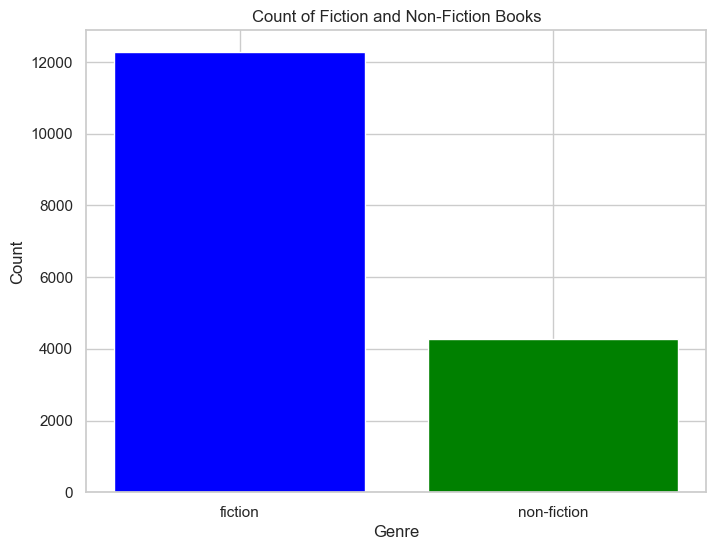

In [15]:
# Set the figsize parameter to control the size of the figure
plt.figure(figsize=(8, 6))

# Plot the count of fiction and non-fiction books
bar_width = 0.05

plt.bar(genre_count.index, genre_count.values, color=['blue', 'green'])
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Count of Fiction and Non-Fiction Books')
plt.show()

In [16]:
# There is more data in the fiction category, so I'm going to create a new dataframe with only the fiction books.
# My models will only be trained with the fiction genres.

fiction = clean[clean['field'] != 'non-fiction']

In [17]:
fiction = fiction.drop(columns=['field'])
fiction.shape

(12275, 3)

In [18]:
def genre_lists(string):
    fan = ['dystopia', 'cyberpunk', 'steampunk', 'alien invasion', 'apocalyptic', 'science fiction', 'fantasy', 'horror', 'gothic']
    thriller = ['thriller', 'crime fiction', 'suspense', 'spy fiction', 'detective fiction', 'mystery']
    true_crime = ['true crime']
    historical = ['historical', 'history', 'western']
    romance = ['chivalric', 'romantic', 'romance', 'erotica', 'pornography']
    comical = ['comedy', 'comical', 'comic novel', 'black comedy', 'humour', 'parody', 'satire']
    poetry = ['poetry']
    travel = ['travel literature']
    children = ["children's literature", 'fairy tale']
    lit = ['magic realism', 'roman', 'literary realism', 'prose']


    genre_lower = string.lower()

    if any(keyword in genre_lower for keyword in fan):
        if 'horror' in genre_lower or 'gothic' in genre_lower:
            return 'horror'
        else:
            return 'fantasy & science fiction'
    elif any(keyword in genre_lower for keyword in thriller):
        return 'thriller'
    elif any(keyword in genre_lower for keyword in true_crime):
        return 'true crime'
    elif any(keyword in genre_lower for keyword in historical):
        return 'historical novel'
    elif any(keyword in genre_lower for keyword in romance):
        return 'romance novel'
    elif any(keyword in genre_lower for keyword in comical):
        return 'comedy'
    elif any(keyword in genre_lower for keyword in poetry):
        return 'poetry'
    elif 'ergodic' in string.lower():
        return 'ergodic'
    elif any(keyword in genre_lower for keyword in children):
        return 'children literature'
    elif any(keyword in genre_lower for keyword in lit):
        return 'literary fiction'
    else:
        return 'literary fiction'

# clean['genre'] = clean['genre'].apply(genre_lists)
 

In [19]:
fiction['standard_genre'] = fiction['genre'].apply(genre_lists)

In [20]:
fiction.sample(4)

,title,genre,summary,standard_genre
3992,Gilead,"{""/m/02xlf"": ""Fiction"", ""/m/05hgj"": ""Novel""}",The book is an account of the memories and le...,literary fiction
11312,Men of Stone,"{""/m/0dwly"": ""Children's literature""}","The novel follows protagonist Ben Conrad, a f...",children literature
16244,The Russian Concubine,"{""/m/02p0szs"": ""Historical fiction""}",The story begins in 1917 when a five-year-old...,historical novel
10397,Sard Harker,"{""/m/02xlf"": ""Fiction"", ""/m/08sdrw"": ""Adventur...",The novel commences with establishing narrati...,literary fiction


In [21]:
fiction.standard_genre.value_counts()

standard_genre
fantasy & science fiction    4546
literary fiction             2819
thriller                     2056
children literature           929
historical novel              873
horror                        590
comedy                        231
romance novel                 204
true crime                     13
poetry                         12
ergodic                         2
Name: count, dtype: int64

In [22]:
fiction.shape

(12275, 4)

In [23]:
# We'll drop the "true crime", "ergodic" and "poetry" books because there aren't many samples of each.

novel = fiction[~fiction['standard_genre'].isin(['true crime', 'ergodic', 'poetry'])]
novel.shape

(12248, 4)

In [24]:
novel.standard_genre.value_counts()

standard_genre
fantasy & science fiction    4546
literary fiction             2819
thriller                     2056
children literature           929
historical novel              873
horror                        590
comedy                        231
romance novel                 204
Name: count, dtype: int64

I'll drop the category of 'children literature' because it really doesn't give us information about the topic, 
but rather the age of the target readers.

In [26]:
adults = novel[~novel['standard_genre'].isin(['children literature'])]
adults.shape

(11319, 4)

In [27]:
adults_count = adults.standard_genre.value_counts()
adults_count

standard_genre
fantasy & science fiction    4546
literary fiction             2819
thriller                     2056
historical novel              873
horror                        590
comedy                        231
romance novel                 204
Name: count, dtype: int64

In [28]:
adults.sample(3)

,title,genre,summary,standard_genre
2182,And Quiet Flows the Don,"{""/m/05hgj"": ""Novel""}",The novel deals with the life of the Cossacks...,literary fiction
14237,Escape from the Forest,"{""/m/0dwly"": ""Children's literature"", ""/m/01hm...",The book opens to Sasha refusing Tigerstar's ...,fantasy & science fiction
8767,Star Wars Republic Commando: True Colors,"{""/m/06n90"": ""Science Fiction"", ""/m/014dfn"": ""...",In the Grand Army's desperate fight to crush ...,fantasy & science fiction


In [29]:
# I create a function to clean the standard_genre of 'fantasy & science fiction'.

def fant_sci(string):
    sci_fi_keywords = ['dystopia', 'cyberpunk', 'steampunk', 'alien invasion', 'apocalyptic']
    
    genre_lower = string.lower()

    if any(keyword in genre_lower for keyword in sci_fi_keywords):
        return 'science fiction'
    elif 'fantasy' in genre_lower and 'science fiction' not in genre_lower:
        return 'fantasy'
    elif 'science fiction' in genre_lower and 'fantasy' not in genre_lower:
        return 'science fiction'
    else:
        return 'fantasy & science fiction'

In [30]:
fant_mask = adults['standard_genre'] == 'fantasy & science fiction'
adults.loc[fant_mask, 'standard_genre'] = adults.loc[fant_mask, 'genre'].apply(fant_sci)
adults.sample(5)

,title,genre,summary,standard_genre
15912,Let It Snow,"{""/m/03mfnf"": ""Young adult literature""}","Jubilee Dougal, just a typical teenager, find...",literary fiction
13659,The Fair Bride,"{""/m/05hgj"": ""Novel""}",A priest finds himself on the run from the Sp...,literary fiction
8144,The Borgia Bride,"{""/m/0hwxm"": ""Historical novel""}",The book starts off with Princess Sancha reme...,historical novel
12987,A Darker Domain,"{""/m/0lsxr"": ""Crime Fiction""}","During the infamous UK miners' strike, a weal...",thriller
7716,Bikini Planet,"{""/m/06n90"": ""Science Fiction"", ""/m/01z4y"": ""C...","Waking in the 24th Century, Wayne claims to b...",science fiction


In [31]:
adults_count = adults.standard_genre.value_counts()
adults_count

standard_genre
literary fiction             2819
science fiction              2302
thriller                     2056
fantasy                      1695
historical novel              873
horror                        590
fantasy & science fiction     549
comedy                        231
romance novel                 204
Name: count, dtype: int64

In [32]:
# I drop the three lasts genres (the ones that have less data).
# I want to keep less categories for efficiency purposes or for computer expenses when training.

six_genres = adults[~adults['standard_genre'].isin(['fantasy & science fiction', 'comedy', 'romance novel'])]
six_genres.head(4)

,title,genre,summary,standard_genre
1,A Clockwork Orange,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan...",science fiction
2,The Plague,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...,literary fiction
5,All Quiet on the Western Front,"{""/m/098tmk"": ""War novel"", ""/m/016lj8"": ""Roman...","The book tells the story of Paul Bäumer, a Ge...",literary fiction
6,A Wizard of Earthsea,"{""/m/0dwly"": ""Children's literature"", ""/m/01hm...","Ged is a young boy on Gont, one of the larger...",fantasy


In [33]:
six_count = six_genres.standard_genre.value_counts()
six_count

standard_genre
literary fiction    2819
science fiction     2302
thriller            2056
fantasy             1695
historical novel     873
horror               590
Name: count, dtype: int64

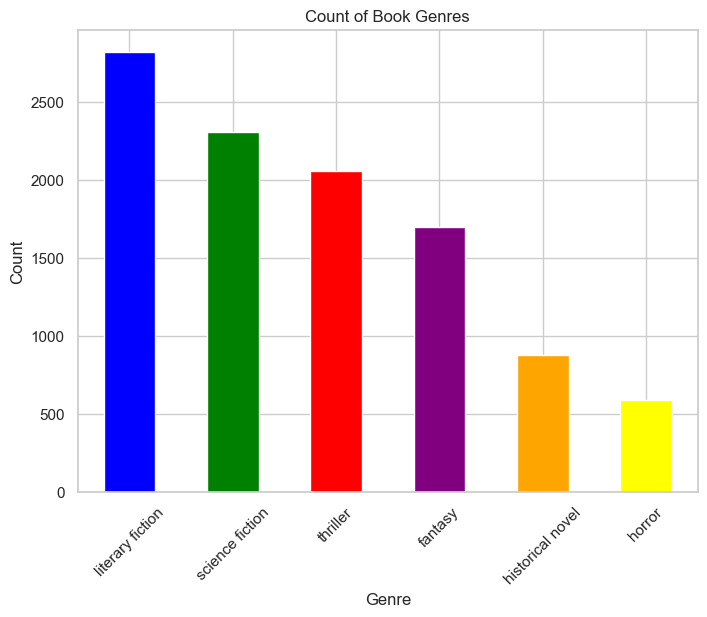

In [34]:
# I'm going to plot the count for each book genre.

# Set the figsize parameter to control the size of the figure
plt.figure(figsize=(8, 6))

six_count.plot(kind='bar', color=['blue', 'green', 'red', 'purple', 'orange', 'yellow'])
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Count of Book Genres')
plt.xticks(rotation=45) 
plt.show()

In [35]:
six_genres.shape

(10335, 4)

In [36]:
six_genres.sample(2)

,title,genre,summary,standard_genre
6890,The First Casualty,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/014dfn"": ""Sp...","In June 1917, whilst recovering from shell sh...",thriller
5222,The Smell of Apples,"{""/m/02xlf"": ""Fiction"", ""/m/05hgj"": ""Novel""}",Marnus Erasmus is an eleven-year-old boy who ...,literary fiction


In [37]:
six = six_genres.drop(columns='genre')

In [38]:
six.sample(4)

,title,summary,standard_genre
8586,Blaze,"* The story concerns Clayton Blaisdell, Jr. (...",horror
8874,Down There on a Visit,Throughout the novel Isherwood is a character...,literary fiction
2580,"Repent, Harlequin! Said the Ticktockman",The story opens with a passage from Civil Dis...,literary fiction
5071,Mister Monday,"On Earth, a boy named Arthur Penhaligon is at...",fantasy


In [39]:
six.rename(columns={'standard_genre': 'genre'}, inplace=True)
six.head(2)

,title,summary,genre
1,A Clockwork Orange,"Alex, a teenager living in near-future Englan...",science fiction
2,The Plague,The text of The Plague is divided into five p...,literary fiction


#### 5.2. I import a new dataset to increase my book genre samples.

In [40]:
books = pd.read_csv("/Users/usuari/Desktop/Ironhack/BOOTCAMP/projects/final_project/data/more_books.csv")
books.head(5)

,index,title,genre,summary
0,0,Drowned Wednesday,fantasy,Drowned Wednesday is the first Trustee among ...
1,1,The Lost Hero,fantasy,"As the book opens, Jason awakens on a school ..."
2,2,The Eyes of the Overworld,fantasy,Cugel is easily persuaded by the merchant Fia...
3,3,Magic's Promise,fantasy,The book opens with Herald-Mage Vanyel return...
4,4,Taran Wanderer,fantasy,Taran and Gurgi have returned to Caer Dallben...


In [41]:
books.genre.value_counts()

genre
thriller      1023
fantasy        876
science        647
history        600
horror         600
crime          500
romance        111
psychology     100
sports         100
travel         100
Name: count, dtype: int64

In [42]:
books = books.drop(columns='index')
books.shape

(4657, 3)

In [43]:
# I want to check if in this new dataset, the books classified as 'history' are essays or historical novels.

hist = books[books['genre'] == 'history']
hist.head(4)

,title,genre,summary
1500,Smuggler's Moon,history,Sir John and Jeremy are sent to East Anglia t...
1501,An Experiment In Treason,history,A pack of confidential letters is stolen from...
1502,War and Peace,history,"War and Peace has a large cast of characters,..."
1503,The First Sir Percy,history,March 1624 and a lot has happened since the p...


In [44]:
# I can see that they are historical novels. 

list(set(hist.summary))[:10]

[" From Dahomey to the slave state of Mississippi, Flashman has cause to regret a game of pontoon with Benjamin Disraeli and Lord George Bentinck. From his ambition for a seat in the House of Commons, he has to settle instead for a role in the West African slave trade, under the command of Captain John Charity Spring, a Latin-spouting madman. Captured by the United States Navy, Flashman has to talk his way out of prison by assuming the first of his many false identities in America. After a visit to Washington D.C. and an unsettling meeting with Abraham Lincoln (still a junior congressman at the time), he escapes his Navy protectors in New Orleans and holes up at a whorehouse run by an amorous madame, Susie Willinck. He is again taken into custody, this time by members of the Underground Railroad. Traveling up the Mississippi River with a fugitive slave ends badly once again, and the rest of the story has Flashman as a slave driver on a plantation, a potential slave himself, and a slave

In [45]:
less = books[~books['genre'].isin(['science', 'crime', 'romance', 'psychology', 'sports', 'travel'])]
less.head(5)

,title,genre,summary
0,Drowned Wednesday,fantasy,Drowned Wednesday is the first Trustee among ...
1,The Lost Hero,fantasy,"As the book opens, Jason awakens on a school ..."
2,The Eyes of the Overworld,fantasy,Cugel is easily persuaded by the merchant Fia...
3,Magic's Promise,fantasy,The book opens with Herald-Mage Vanyel return...
4,Taran Wanderer,fantasy,Taran and Gurgi have returned to Caer Dallben...


In [46]:
less.shape

(3099, 3)

In [47]:
less.genre.value_counts()

genre
thriller    1023
fantasy      876
history      600
horror       600
Name: count, dtype: int64

In [48]:
# I want to check if in this new dataset, the books classified as 'fantasy' are really fantasy books. 
# Perhaps they are instead "fantasy & science fiction" books. 

fanta = less[less['genre'] == 'fantasy']
fanta.head(4)

,title,genre,summary
0,Drowned Wednesday,fantasy,Drowned Wednesday is the first Trustee among ...
1,The Lost Hero,fantasy,"As the book opens, Jason awakens on a school ..."
2,The Eyes of the Overworld,fantasy,Cugel is easily persuaded by the merchant Fia...
3,Magic's Promise,fantasy,The book opens with Herald-Mage Vanyel return...


In [70]:
# It seems that the books classifies as "fantasy" are really fantasy stories rather than science fiction. 

list(set(fanta.summary))[208]

' Two explorers travel miles beneath Mount Rainier and discover a cavernous realm, filled with glowing mist, called Drome, which is home to a lost civilization and fantastic animals, including bat-apes, snake-cats, and tree-octopi.'

In [54]:
# I define the new order of columns
new_order = ['title', 'summary', 'genre']

# Reorder columns
less = less[new_order]
less.sample(2)

,title,summary,genre
4522,Theft of Swords,"Royce Melborn, a skilled thief, and his mercen...",fantasy
4525,The Demon King,Times are hard in the mountain city of Fellsma...,fantasy


In [55]:
less.genre.value_counts()

genre
thriller    1023
fantasy      876
history      600
horror       600
Name: count, dtype: int64

In [56]:
six.genre.value_counts()

genre
literary fiction    2819
science fiction     2302
thriller            2056
fantasy             1695
historical novel     873
horror               590
Name: count, dtype: int64

In [57]:
less['genre'] = less['genre'].replace('history', 'historical novel')
less.genre.value_counts()

genre
thriller            1023
fantasy              876
historical novel     600
horror               600
Name: count, dtype: int64

In [60]:
print(six.shape)
less.shape

(10335, 3)


(3099, 3)

#### 5.3. Now I'm going to join the two datasets.

In [58]:
joined = pd.concat([six, less], ignore_index=True)
joined.head(8)

,title,summary,genre
0,A Clockwork Orange,"Alex, a teenager living in near-future Englan...",science fiction
1,The Plague,The text of The Plague is divided into five p...,literary fiction
2,All Quiet on the Western Front,"The book tells the story of Paul Bäumer, a Ge...",literary fiction
3,A Wizard of Earthsea,"Ged is a young boy on Gont, one of the larger...",fantasy
4,Blade Runner 3: Replicant Night,"Living on Mars, Deckard is acting as a consul...",science fiction
5,Blade Runner 2: The Edge of Human,Beginning several months after the events in ...,science fiction
6,Crash,The story is told through the eyes of narrato...,literary fiction
7,Children of Dune,Nine years after Emperor Paul Muad'dib walked...,science fiction


In [59]:
joined.shape

(13434, 3)

In [62]:
joined.duplicated().sum()

1730

In [63]:
join = joined.drop_duplicates()
join.duplicated().sum()

0

In [64]:
join.shape

(11704, 3)

In [66]:
join.genre.value_counts()

genre
literary fiction    2819
thriller            2634
science fiction     2302
fantasy             2210
historical novel    1048
horror               691
Name: count, dtype: int64

In [ ]:
# Maybe we should drop the 'horror' column because it is the category with less samples.
# we want a balanced dataset so that our models are better trained. 

In [71]:
five = join[~join['genre'].isin(['horror'])]
five.shape

(11013, 3)

In [72]:
five_counts = five.genre.value_counts()
five_counts

genre
literary fiction    2819
thriller            2634
science fiction     2302
fantasy             2210
historical novel    1048
Name: count, dtype: int64

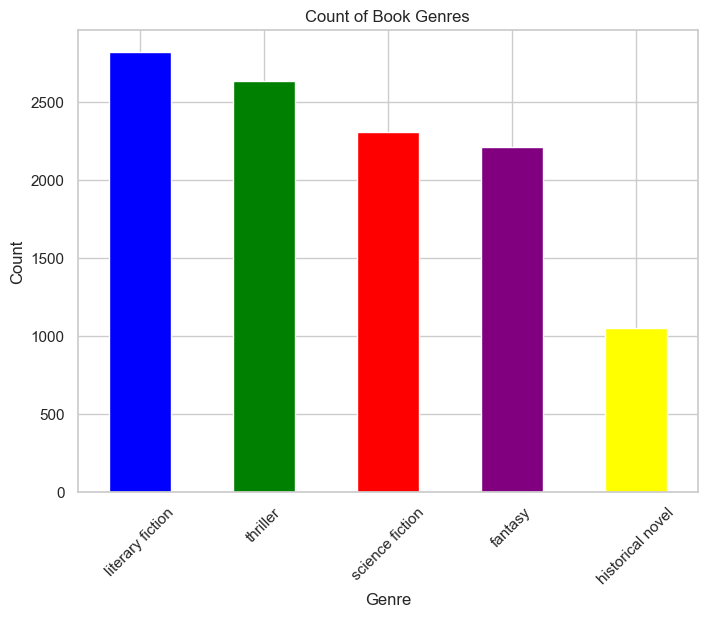

In [73]:
# Set the figsize parameter to control the size of the figure
plt.figure(figsize=(8, 6))

five_counts.plot(kind='bar', color=['blue', 'green', 'red', 'purple', 'yellow'])
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Count of Book Genres')
plt.xticks(rotation=45) 
plt.show()

In [74]:
# I save my dataframe with the changes saved:

five.to_csv("five.csv", index=False)

# Specify the folder path and filename for the CSV file
folder_path = "/Users/usuari/Desktop/Ironhack/BOOTCAMP/projects/final_project/data"
file_name = "five.csv"

# Combine the folder path and filename to create the full file path
full_file_path = f"{folder_path}/{file_name}"

# Export the DataFrame to the specified folder
five.to_csv(full_file_path, index=False)